In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
import os
import zipfile

2.2.0-rc1


In [0]:
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

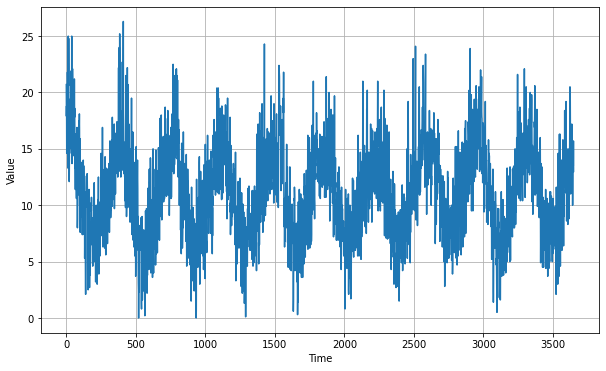

In [41]:
import csv
time_step = []
temp = []

with open('daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    temp.append(float(row[1]))
range=len(temp)
time_step=np.arange(0,range)  
series = np.array(temp)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series) 

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)



In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


window_size = 30
batch_size = 32

shuffle_buffer_size = 1000

In [70]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 20
batch_size = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [72]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, 
                         kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None,1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
12/12 [==============================] - 3s 281ms/step - loss: 89.2133 - mae: 89.7981 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 3s 280ms/step - loss: 84.8645 - mae: 85.4677 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 3s 284ms/step - loss: 78.6514 - mae: 79.2972 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 3s 281ms/step - loss: 71.8065 - mae: 72.4387 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 3s 283ms/step - loss: 64.5411 - mae: 65.2247 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 3s 284ms/step - loss: 56.9352 - mae: 57.6219 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 3s 280ms/step - loss: 48.8309 - mae: 49.5294 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 3s 280ms/step - loss: 40.3116 - mae: 41.0088 - lr: 2.2387e-08
Epoch 9/100
12/12 [==============================] - 3s 281ms/step - loss: 32.10

(1e-08, 0.0001, 0.0, 60.0)

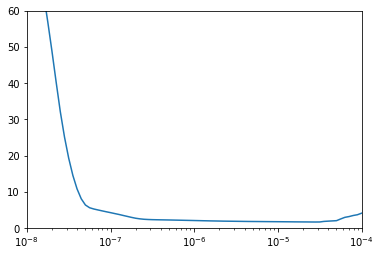

In [73]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [74]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, 
                         kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None,1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500)

Epoch 1/500
12/12 [==============================] - 3s 277ms/step - loss: 28.1376 - mae: 29.7402
Epoch 2/500
12/12 [==============================] - 3s 280ms/step - loss: 8.4817 - mae: 9.1230
Epoch 3/500
12/12 [==============================] - 3s 278ms/step - loss: 5.5865 - mae: 6.1176
Epoch 4/500
12/12 [==============================] - 3s 275ms/step - loss: 4.1521 - mae: 4.6471
Epoch 5/500
12/12 [==============================] - 3s 274ms/step - loss: 3.4446 - mae: 3.9279
Epoch 6/500
12/12 [==============================] - 3s 277ms/step - loss: 3.1579 - mae: 3.6324
Epoch 7/500
12/12 [==============================] - 3s 276ms/step - loss: 2.9460 - mae: 3.4214
Epoch 8/500
12/12 [==============================] - 3s 276ms/step - loss: 2.8350 - mae: 3.3049
Epoch 9/500
12/12 [==============================] - 3s 273ms/step - loss: 2.7524 - mae: 3.2233
Epoch 10/500
12/12 [==============================] - 3s 277ms/step - loss: 2.6811 - mae: 3.1501
Epoch 11/500
12/12 [=================

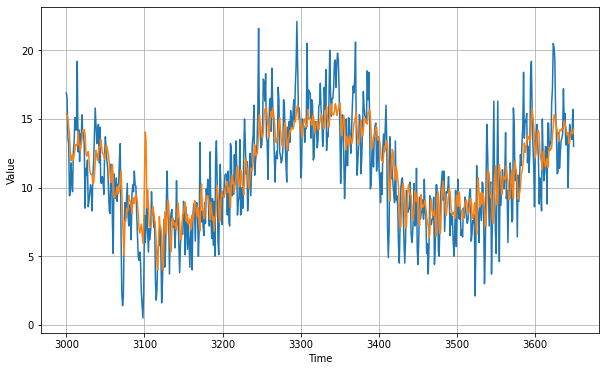

In [76]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [77]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.9315039

In [78]:
print(rnn_forecast)

[15.377659  15.285712  15.071344  14.378169  13.938475  12.774749
 11.942548  12.330429  12.368922  11.999234  12.402494  12.751746
 13.129939  13.128664  13.04082   14.066741  13.160643  13.077175
 12.673884  13.123425  13.495014  14.169322  14.216278  14.204198
 13.9373455 12.6172085 12.299609  12.366083  12.627937  12.06326
 11.287613  10.983483  10.954539  10.887061  10.273415  10.34984
 10.922846  11.854538  12.705371  12.490246  11.986613  12.39187
 12.950118  12.904922  13.51403   13.081023  12.576535  12.435269
 12.375997  12.0496435 12.502564  13.073937  12.98238   12.689656
 12.357473  11.75998   10.986559  10.366397  11.081438  11.679482
 10.829409   9.258611   9.257119   9.424494   9.685917  10.0548525
  9.554518   9.61837    9.772556  10.3984375 11.164654   9.808018
  7.655289   6.0964627  5.059568   7.5611157  7.5415688  8.451362
  8.251269   8.402544   9.420552   9.069014   9.009473   8.593636
  8.101876   8.9663315  9.234545   8.843038   9.380901   9.37437
  9.381481   